In [2]:
import json
import os
import requests
import urllib

In [17]:
SPOTIFY_ACCESS_TOKEN = os.environ.get('SPOTIFY_ACCESS_TOKEN')
if not SPOTIFY_ACCESS_TOKEN:
    raise Exception('Spotify Access Token not available as an environment variable. Please set it before continuing.')
MOVIE_DB_KEY = os.environ.get('MOVIE_DB_KEY')
if not MOVIE_DB_KEY:
    raise Exception('Movie DB API key not available as an environment variable. Please set it before continuing.')

In [9]:
def get_all_movie_titles_for_genre(genre_id):
    movie_res = requests.get('https://api.themoviedb.org/3/genre/{}/movies?api_key={}'.format(genre_id, MOVIE_DB_KEY))
    movie_list = json.loads(movie_res.text).get('results')
    for movie in movie_list:
        yield movie.get('title')


def get_movie_soundtrack_popularity(movie):
    # this spotify access token will expire.
    headers = {
        'Authorization': 'Bearer {}'.format(SPOTIFY_ACCESS_TOKEN)
    }
    params = urllib.urlencode({'q': movie.encode('utf8'), 'type': 'album', 'limit': 1})

    # we're making a search for the album name by using the movie name. we're only asking for the first search result
    st_res = requests.get('https://api.spotify.com/v1/search', headers=headers, params=params)

    album_text = json.loads(st_res.text).get('albums')
    if not album_text:
        return 0

    album_items = album_text.get('items')
    if not album_items:
        return 0

    # we only asked for the first result in our api request so we know it's the first item and we've already checked that the list exists
    album_id = album_items[0].get('id')
    album_res = requests.get('https://api.spotify.com/v1/albums/{}'.format(album_id), headers=headers)
    return json.loads(album_res.text).get('popularity')


def get_movie_soundtrack_popularity_avg_by_genre(genre_id):
    movie_titles = get_all_movie_titles_for_genre(genre_id)
    total_score = 0
    movie_count = 0

    for movie in movie_titles:
        pop_score = get_movie_soundtrack_popularity(movie)
        if not pop_score:
            continue
        total_score += pop_score
        movie_count += 1
        
    if movie_count == 0:
        return None

    return (total_score / movie_count)

def get_movie_music_popularity_scores():
    movie_music_list = []
    genre_reponse = requests.get('https://api.themoviedb.org/3/genre/movie/list?api_key={}'.format(MOVIE_DB_KEY))
    all_genre_list = json.loads(genre_reponse.text).get('genres')
    for genre_dict in all_genre_list:
        pop_score_avg = get_movie_soundtrack_popularity_avg_by_genre(genre_dict.get('id'))
        if not pop_score_avg:
            continue
        movie_music_list.append({
            'genre': genre_dict.get('name'),
            'popularity_avg': pop_score_avg
        })
        
    return movie_music_list


In [10]:
movie_music_list = get_movie_music_popularity_scores()

In [11]:
print(movie_music_list)

[{'genre': u'Action', 'popularity_avg': 49}, {'genre': u'Adventure', 'popularity_avg': 54}, {'genre': u'Animation', 'popularity_avg': 51}, {'genre': u'Comedy', 'popularity_avg': 50}, {'genre': u'Crime', 'popularity_avg': 51}, {'genre': u'Documentary', 'popularity_avg': 43}, {'genre': u'Drama', 'popularity_avg': 54}, {'genre': u'Family', 'popularity_avg': 54}, {'genre': u'Fantasy', 'popularity_avg': 52}, {'genre': u'History', 'popularity_avg': 42}, {'genre': u'Horror', 'popularity_avg': 41}, {'genre': u'Music', 'popularity_avg': 54}, {'genre': u'Mystery', 'popularity_avg': 46}, {'genre': u'Romance', 'popularity_avg': 55}, {'genre': u'Science Fiction', 'popularity_avg': 50}, {'genre': u'TV Movie', 'popularity_avg': 40}, {'genre': u'Thriller', 'popularity_avg': 48}, {'genre': u'War', 'popularity_avg': 40}, {'genre': u'Western', 'popularity_avg': 36}]


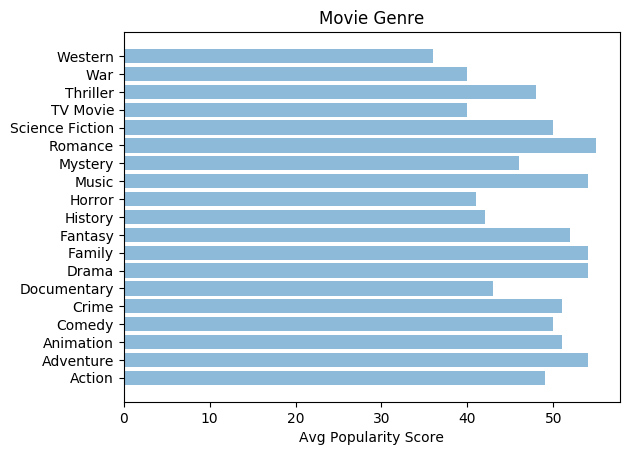

In [15]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcdefaults() 
genres = [movie_music.get('genre') for movie_music in movie_music_list]
y_pos = np.arange(len(genres))
popularity_scores = [movie_music.get('popularity_avg') for movie_music in movie_music_list]
 
plt.barh(y_pos, popularity_scores, align='center', alpha=0.5)
plt.yticks(y_pos, genres)
plt.xlabel('Avg Popularity Score')
plt.title('Movie Genre')
 
plt.show()